In [1]:
import json
from tqdm import tqdm
import pandas as pd
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

### Analizamos las longitudes en tokens del dataset

In [2]:
tokenizer = AutoTokenizer.from_pretrained("BSC-LT/salamandra-7b-instruct")
dataset = json.load(open('../description_train_dataset.json', 'r'))
df = pd.DataFrame(dataset)

100%|██████████| 5/5 [00:56<00:00, 11.32s/it]


Key Prompt has maximum token length of 66.
Key Gemini has maximum token length of 272.
Key Descripcion has maximum token length of 1608.
Key Nueva Descripcion has maximum token length of 728.
Key SQL has maximum token length of 4030.


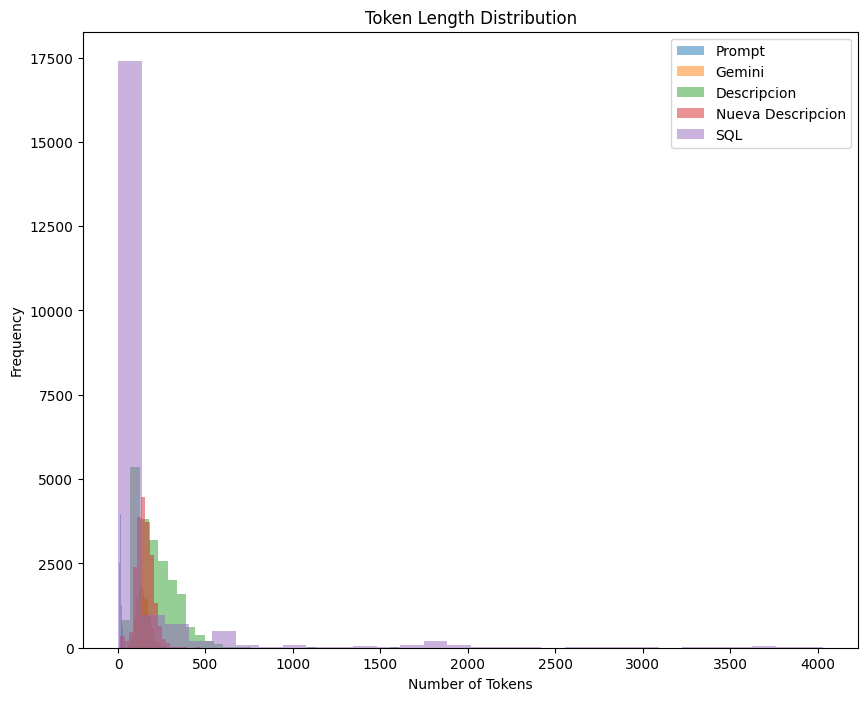

In [3]:
columns = {'Prompt', 'Descripcion', 'Gemini', 'SQL', 'Nueva Descripcion'}
for key in tqdm(columns):
    df[f'{key} length'] = df[key].apply(lambda x: len(tokenizer(x)['input_ids']))

for key in columns:
    print(f"Key {key} has maximum token length of {max(df[f'{key} length'])}.")

plt.figure(figsize=(10,8))
for key in columns:
    plt.hist(df[f'{key} length'], bins=30, alpha=0.5, label=key)
plt.legend()
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

### Empieza el filtrado

#### Eliminar nuevas descripciones excesivamente cortas, ya que no se habrán generado correctamente.

In [4]:
lengths = df[df['Nueva Descripcion length'] < 75]
print(len(lengths))
lengths['Prompt'].value_counts()

684


Prompt
Descripciones de una línea y nada más                                                                                                                              159
Limita cada descripción a una sola línea.                                                                                                                          159
Describe cada especie en una sola línea, sin extenderte.                                                                                                           159
Escribe las características más llamativas en forma de lista de puntos clave.                                                                                       17
Enumera las características más notables de forma esquemática.                                                                                                      17
Haz una lista con los características más importantes de las especies.                                                                                        

In [5]:
# Necesitamos dejar las tres primeras
df = df[(df['Nueva Descripcion length'] >= 75) | df['Prompt'].isin(['Descripciones de una línea y nada más', 'Limita cada descripción a una sola línea.', 'Describe cada especie en una sola línea, sin extenderte.'])]

#### Eliminar descripciones demasiado largas

In [6]:
# Dado que las descripciones a adaptar como mucho alcanzan los 272 tokens, buscamos aquellas que aumentan considerablemente esa cantidad
lengths = df[df['Nueva Descripcion length'] >= 325]
print(len(lengths))
lengths['Prompt'].value_counts()

114


Prompt
Haz las descripciones más técnicas e incluye información de los géneros en ellas                       33
Haz descripciones más formales y detalladas, incluyendo siempre la información del género.             33
Utiliza terminología científica y asegúrate de incluir información sobre el género de cada especie.    33
Quiero la familia y otros nombres comunes                                                               3
Me interesa saber a qué familia pertenecen y qué otros nombres comunes tienen                           3
Puedes darme la familia y otros nombres comunes?                                                        3
Por favor, céntrate en la taxonomía de la especie e incluye información de los géneros.                 2
¿Puedes centrarte más en la taxonomía e incorporar datos sobre los géneros?                             2
Quiero que la descripción se enfoque en la taxonomía, incluyendo detalles sobre los géneros.            2
Name: count, dtype: int64

In [7]:
df = df[df['Nueva Descripcion length'] < 325]

#### Filtrar ejemplos con demasiada información en la columna SQL

In [ ]:
# No deberian ser necesarios mas de 2048 tokens para el contexto SQL
lengths = df[df['SQL length'] > 2048]
print(len(lengths))
lengths['Prompt'].value_counts()

531


Prompt
¿Me puedes indicar si puedo ver estas especies en otras rutas?                               90
Quiero saber si puedo encontrar estas especies en otras rutas                                90
Dame más rutas donde pueda ver a estas especies                                              90
Rutas de menos de 15 km donde aparezcan                                                      54
incluye ejemplos de rutas de menos de 15 km donde pueda ver estas especies                   54
en q rutas < 15 km se han registrado estas especies?                                         54
Puedes incluir la taxonomía de las especies y las provincias donde puedo encontrarlas?       18
Quiero ver la taxonomía y la distribución por provincias de cada especie.                    18
Taxonomía y provincias donde aparecen                                                        18
Añade a la descripción si se ha observado en alguna ruta cuya longitud sea mayor de 50 km     9
Presencia en rutas largas (más de

In [9]:
# Eliminamos las filas resultantes
df = df[df['SQL length'] <= 2048]

### Volver a analizar las longitudes

100%|██████████| 5/5 [01:12<00:00, 14.51s/it]


Key Prompt has maximum token length of 66.
Key Gemini has maximum token length of 272.
Key Descripcion has maximum token length of 1608.
Key Nueva Descripcion has maximum token length of 324.
Key SQL has maximum token length of 2007.


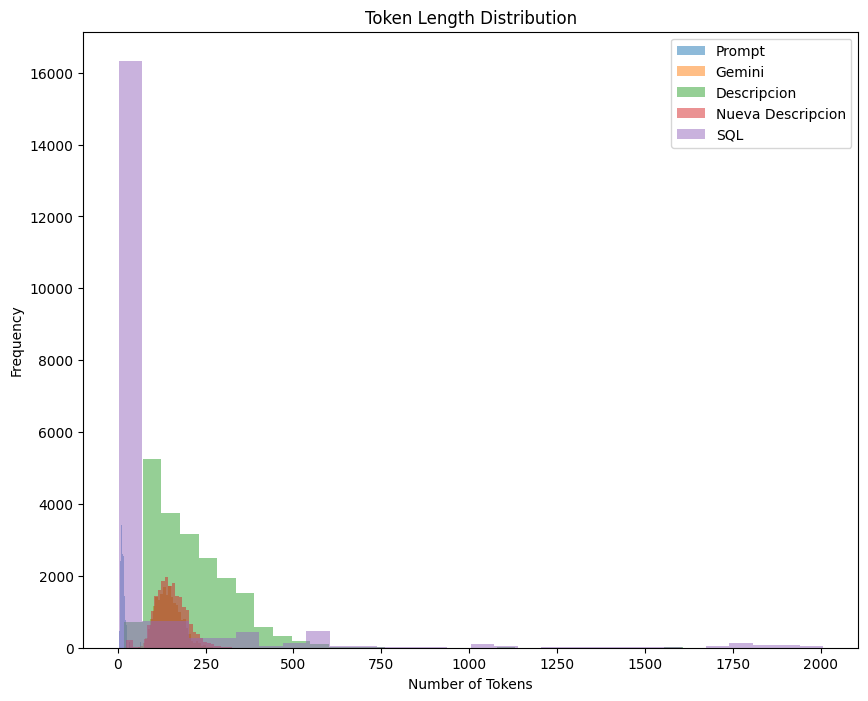

In [10]:
columns = {'Prompt', 'Descripcion', 'Gemini', 'SQL', 'Nueva Descripcion'}
for key in tqdm(columns):
    df[f'{key} length'] = df[key].apply(lambda x: len(tokenizer(x)['input_ids']))

for key in columns:
    print(f"Key {key} has maximum token length of {max(df[f'{key} length'])}.")

plt.figure(figsize=(10,8))
for key in columns:
    plt.hist(df[f'{key} length'], bins=30, alpha=0.5, label=key)
plt.legend()
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

### Guardamos el dataset actualizado

In [11]:
with open('../description_train_dataset.json', 'w') as f:
    json.dump(df.to_dict(orient='records'), f)

## Generar una versión reducida del dataset para poder realizar finetuning sin que lleve tanto tiempo

In [15]:
tokenizer = AutoTokenizer.from_pretrained("BSC-LT/salamandra-7b-instruct")
dataset = json.load(open('../description_train_dataset.json', 'r'))
df = pd.DataFrame(dataset)

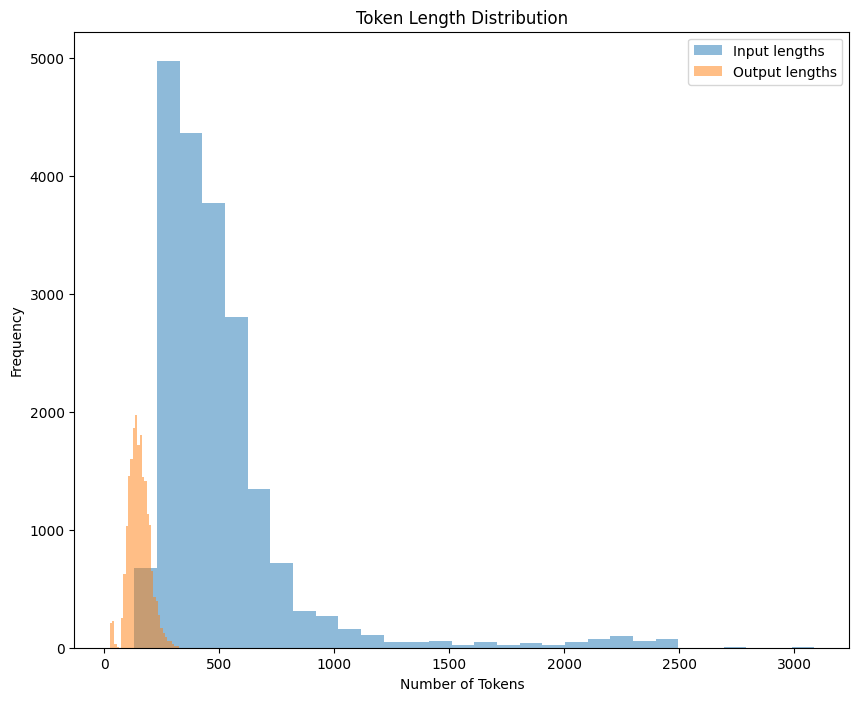

Max input length: 3088
Max output length: 324


In [4]:
input_template = """### Prompt:::

{prompt}

### Descripcion a adaptar:::

{descripcion_a_adaptar}

### Descripción científica:::

{descripcion_cientifica}

### Información adicional:::

{informacion_adicional}

### Nueva descripción:::

"""

input_lengths = [len(tokenizer(
        input_template.format(
            prompt=row['Prompt'],
            descripcion_a_adaptar=row['Gemini'],
            descripcion_cientifica=row['Descripcion'],
            informacion_adicional=row['SQL']
        )
    )['input_ids']) for row in dataset]
output_lengths = [len(tokenizer(row['Nueva Descripcion'])['input_ids']) for row in dataset]

plt.figure(figsize=(10,8))
plt.hist(input_lengths, bins=30, alpha=0.5, label='Input lengths')
plt.hist(output_lengths, bins=30, alpha=0.5, label='Output lengths')
plt.legend()
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

print(f"Max input length: {max(input_lengths)}")
print(f"Max output length: {max(output_lengths)}")

#### Eliminamos instancias con input_length grande

In [5]:
for token_limit in range(500, 2001, 75):
    print(f"Instancias con longitud mayor a {token_limit}: {len([True for l in input_lengths if l > token_limit])} / {len(input_lengths)}")

Instancias con longitud mayor a 500: 7180 / 20154
Instancias con longitud mayor a 575: 4877 / 20154
Instancias con longitud mayor a 650: 3079 / 20154
Instancias con longitud mayor a 725: 2205 / 20154
Instancias con longitud mayor a 800: 1655 / 20154
Instancias con longitud mayor a 875: 1304 / 20154
Instancias con longitud mayor a 950: 1133 / 20154
Instancias con longitud mayor a 1025: 913 / 20154
Instancias con longitud mayor a 1100: 795 / 20154
Instancias con longitud mayor a 1175: 710 / 20154
Instancias con longitud mayor a 1250: 647 / 20154
Instancias con longitud mayor a 1325: 617 / 20154
Instancias con longitud mayor a 1400: 574 / 20154
Instancias con longitud mayor a 1475: 531 / 20154
Instancias con longitud mayor a 1550: 504 / 20154
Instancias con longitud mayor a 1625: 491 / 20154
Instancias con longitud mayor a 1700: 450 / 20154
Instancias con longitud mayor a 1775: 441 / 20154
Instancias con longitud mayor a 1850: 396 / 20154
Instancias con longitud mayor a 1925: 378 / 20154


In [6]:
# A la vista de lo anterior, nos quedamos con 1250, valor a partir del cual no hay tantos ejemplos
df = df[[True if l <= 1250 else False for l in input_lengths]]

#### Reducir el número de ejemplos

In [7]:
EXAMPLES_PER_PROMPT = 25
prompts = set(df['Prompt'])
dfs = []
for p in prompts:
    prompt_df = df[df['Prompt'] == p]
    # Nos quedamos con los ultimos para conservar los ejemplos a mano
    dfs.append(prompt_df.iloc[-EXAMPLES_PER_PROMPT:])
df = pd.concat(dfs)
len(df)

3300

#### Guardar la fracción del dataset

In [8]:
with open('../mini_description_train_dataset.json', 'w') as f:
    json.dump(df.to_dict(orient='records'), f)

#### Hacemos lo mismo con el dataset de test

In [9]:
dataset = json.load(open('../description_test_dataset.json', 'r'))
df = pd.DataFrame(dataset)

In [16]:
df['Prompt'].value_counts()

Prompt
Quiero descripciones que incluyan los nombres comunes de las especies en inglés, si existen.                                                                                        18
Por favor, añade los nombres en inglés, si los hay.                                                                                                                                 18
Quiero que aparezcan los nombres comunes en inglés junto a la descripción.                                                                                                          18
Al principio de cada descripción, añade "Color: <color>", donde <color> es el color de la especie. Si no lo sabes, pon "Color: Desconocido".                                        18
Incluye al inicio de cada descripción la línea 'Color: <color>', reemplazando <color> por el color característico de la especie. Si no se menciona, indica 'Color: Desconocido'.    18
Añade una línea inicial en cada descripción con el formato 'Color: <color>'. U

In [17]:
# Nos quedamos con los 3 ultimos taxones, que son 9 registros
EXAMPLES_PER_PROMPT = 9
prompts = set(df['Prompt'])
dfs = []
for p in prompts:
    prompt_df = df[df['Prompt'] == p]
    # Nos quedamos con los ultimos para conservar los ejemplos a mano
    dfs.append(prompt_df.iloc[-EXAMPLES_PER_PROMPT:])
df = pd.concat(dfs)
len(df)

189

In [18]:
df['idtaxon'].value_counts()

idtaxon
11307    9
11985    9
11047    9
9918     9
11717    9
1009     9
39254    9
10479    9
10559    9
10544    9
26970    9
37976    9
11597    9
39730    9
11816    9
11198    9
16232    9
11114    9
12166    9
12414    9
10534    9
Name: count, dtype: int64

In [ ]:
# Para cada taxon, nos quedamos con uno de cada prompt y uno de cada descripcion gemini
import random
rows = [[0, 4, 8], [0, 5, 7], [1, 3, 8], [1, 5, 6], [2, 3, 7], [2, 4, 6]]  # Asegura prompts distintos
dfs = []
for taxon in set(df['idtaxon']):
    random.seed(taxon)
    selected_rows = random.sample(rows, k=1)
    dfs.append(df[df['idtaxon'] == taxon].iloc[selected_rows[0]])
df = pd.concat(dfs)
len(df)

63

In [29]:
with open('../mini_description_test_dataset.json', 'w') as f:
    json.dump(df.to_dict(orient='records'), f)